## Section 1: Captsone Project Title & Abstract

# DataExplain — Automated Data Insights & Reporting Agent  
### Google 5-Day AI Agents Intensive — Capstone Project  
### Author: Richa Ann Varghese

This project builds a multi-agent system that automatically analyzes tabular datasets, 
generates insights, creates visualizations, evaluates their quality, refines them, 
and produces a clear final report.

The system demonstrates:
- Multi-agent workflow  
- Custom tools (CSV loader, profiler, plot generator, stats tool)  
- Insight generation  
- Agent evaluation  
- Refinement loop  
- Memory  
- Report generation  


## Section 2: Import libraries and Utility Setup

### 2.1 Importing necessary libraries

In [29]:
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
import os
import uuid


### 2.2. Import ADK components
Import the specific components you'll need from the Agent Development Kit and the Generative AI library.

In [30]:
from kaggle_secrets import UserSecretsClient
import google.generativeai as genai
from google.genai import types

from google.adk.agents import LlmAgent
from google.adk.models.google_llm import Gemini
from google.adk.runners import Runner
from google.adk.sessions import InMemorySessionService

print("✅ ADK components imported successfully.")

✅ ADK components imported successfully.


### 2.3 Configure your Gemini API Key

In [31]:


try:
    GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
    os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
    print("✅ Gemini API key setup complete.")
except Exception as e:
    print(
        f"🔑 Authentication Error: Please make sure you have added 'GOOGLE_API_KEY' to your Kaggle secrets. Details: {e}"
    )

✅ Gemini API key setup complete.


### 2.4 Create a Gemini Model Object

In [32]:
# Create the Gemini LLM object used by all agents
gemini_model = Gemini(model_name="gemini-1.5-flash")


In [33]:
import google.generativeai as genai

genai.configure(api_key=os.environ["GOOGLE_API_KEY"])

gpt = genai.GenerativeModel("gemini-2.5-flash-lite")

# Simple helper function to call Gemini and return text
def call_llm(prompt: str):
    response = gpt.generate_content(prompt)
    return response.text


### 2.5 Helper function

In [34]:
call_llm("Say hello in one short sentence.")


'Hello!'

## Section 3: Building Custom Function Tools

Building tools to load data, profile it, generate visualizations, and compute statistics.

### 3.1 load_csv_tool 

This tool loads the CSV file and extracts basic metadata such as column names, data types, and a small preview.
It helps the agents understand the structure of the dataset and understanding how the data looks like before running deeper analysis.

In [35]:
def load_csv_tool(file_bytes: bytes) -> dict:
    """
    Tool: Load CSV file and return dataframe metadata.
    """
    try:
        # Load the CSV into a DataFrame
        df = pd.read_csv(io.BytesIO(file_bytes))

        # Extract basic dataset metadata
        metadata = {
            "columns": list(df.columns),
            "num_rows": len(df),
            "num_columns": df.shape[1],
            "column_types": {col: str(df[col].dtype) for col in df.columns}
        }

        # Return preview and metadata
        return {
            "status": "success",
            "metadata": metadata,
            "preview": df.head(5).to_dict(orient="records")
        }

    except Exception as e:
        # Return error if loading fails
        return {"status": "error", "error": str(e)}


### 3.2 profile_dataframe_tool

This tool computes summary statistics for each column, such as missing percentage, unique values, and basic numeric stats.
It tells us about data quality, potential issues, and overall structure, which helps downstream agents generate meaningful insights.

In [36]:
def profile_dataframe_tool(file_bytes: bytes) -> dict:
    """
    Tool: Profile dataset to compute summary statistics.
    """
    try:
        # Load dataset
        df = pd.read_csv(io.BytesIO(file_bytes))
        profile = {}

        # Compute statistics for each column
        for col in df.columns:
            col_data = df[col]

            # Basic stats applicable to all columns
            profile[col] = {
                "dtype": str(col_data.dtype),
                "missing_pct": float(col_data.isna().mean()),
                "unique_count": int(col_data.nunique()),
            }

            # Add numeric statistics
            if col_data.dtype != "object":
                profile[col].update({
                    "mean": float(col_data.mean()) if col_data.notna().any() else None,
                    "std": float(col_data.std()) if col_data.notna().any() else None,
                    "min": float(col_data.min()) if col_data.notna().any() else None,
                    "max": float(col_data.max()) if col_data.notna().any() else None,
                })

        # Return the full profile
        return {"status": "success", "profile": profile}

    except Exception as e:
        # Error handling
        return {"status": "error", "error": str(e)}


### 3.3 generate_plots_tool
This tool creates visualizations for both numeric and categorical columns.
It generates histograms, boxplots, bar charts, and a correlation heatmap.
These plots help highlight distribution patterns, outliers, category frequencies, and relationships between numeric variables.
Visuals are saved as image files so that other agents (e.g., ReportAgent) can include them in the final output.

In [37]:
# Tool: Generate grouped plots (histograms, boxplots, barplots, heatmap)
# and return both file paths + automated insights.
def generate_plots_tool(file_bytes: bytes):
    try:
        df = pd.read_csv(io.BytesIO(file_bytes))

        # Create plots folder if not exists
        os.makedirs("plots", exist_ok=True)

        numeric_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
        categorical_cols = df.select_dtypes(include=['object','category']).columns.tolist()

        # Storage for results
        results = {
            "histograms": [],
            "boxplots": [],
            "barplots": [],
            "heatmap": None,
            "insights": {
                "histogram_insights": [],
                "boxplot_insights": [],
                "barplot_insights": [],
                "correlation_insights": []
            }
        }

        # ------------------------------
        # 📌 HISTOGRAMS + Insights
        # ------------------------------
        for col in numeric_cols:
            plt.figure()
            df[col].plot(kind="hist", bins=30, edgecolor='black')
            plt.title(f"Histogram of {col}")
            file_path = f"plots/{col}_hist.png"
            plt.savefig(file_path)
            plt.close()

            # Automated histogram insight (skewness)
            skew = df[col].skew()
            if skew > 1:
                insight = f"{col} is highly right-skewed."
            elif skew < -1:
                insight = f"{col} is highly left-skewed."
            else:
                insight = f"{col} distribution is approximately symmetric."

            results["histograms"].append({"column": col, "file": file_path})
            results["insights"]["histogram_insights"].append(insight)

        # ------------------------------
        # 📌 BOX PLOTS + Outlier Insights
        # ------------------------------
        for col in numeric_cols:
            plt.figure()
            df[col].plot(kind="box")
            plt.title(f"Box plot of {col}")
            file_path = f"plots/{col}_box.png"
            plt.savefig(file_path)
            plt.close()

            # Automated outlier detection (IQR)
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            outliers = df[(df[col] < lower) | (df[col] > upper)][col].count()

            if outliers > 0:
                insight = f"{col} contains {outliers} potential outliers."
            else:
                insight = f"{col} shows no significant outliers."

            results["boxplots"].append({"column": col, "file": file_path})
            results["insights"]["boxplot_insights"].append(insight)

        # ------------------------------
        # 📌 BAR PLOTS (categorical) + Class Balance Insights
        # ------------------------------
        for col in categorical_cols:
            plt.figure()
            df[col].value_counts().plot(kind="bar")
            plt.title(f"Bar plot of {col}")
            file_path = f"plots/{col}_bar.png"
            plt.savefig(file_path)
            plt.close()

            # Class balance insight
            value_counts = df[col].value_counts(normalize=True)
            if value_counts.max() > 0.6:
                insight = f"{col} is imbalanced (dominant class = {value_counts.idxmax()})."
            else:
                insight = f"{col} is relatively balanced."

            results["barplots"].append({"column": col, "file": file_path})
            results["insights"]["barplot_insights"].append(insight)

        # ------------------------------
        # 📌 CORRELATION HEATMAP + Correlation Insights
        # ------------------------------
        if len(numeric_cols) > 1:
            plt.figure(figsize=(8, 6))
            corr = df[numeric_cols].corr()
        
            # Use imshow but manually set tick labels
            plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
            plt.colorbar()
        
            # Set title
            plt.title("Correlation Heatmap")
        
            # Set axis ticks
            plt.xticks(ticks=range(len(numeric_cols)), labels=numeric_cols, rotation=45, ha="right")
            plt.yticks(ticks=range(len(numeric_cols)), labels=numeric_cols)
        
            # Tight layout to avoid clipping
            plt.tight_layout()
        
            file_path = "plots/correlation_heatmap.png"
            plt.savefig(file_path)
            plt.close()
        
            results["heatmap"] = file_path
        
            # Identify high correlations
            corr_pairs = corr.abs().unstack()
            corr_pairs = corr_pairs[corr_pairs < 1].sort_values(ascending=False)
            strong_corr = corr_pairs[corr_pairs > 0.75]
        
            if strong_corr.empty:
                results["insights"]["correlation_insights"].append("No strong correlations detected.")
            else:
                for idx, val in strong_corr.items():
                    results["insights"]["correlation_insights"].append(
                        f"Strong correlation: {idx[0]} and {idx[1]} (corr = {round(val,2)})"
                    )
        return {"status": "success", "results": results}

    except Exception as e:
        return {"status": "error", "error": str(e)}


## 2.4 basic_stats_tool
This tool computes simple statistics (mean, median, missing %, unique count) for a single column.
It helps agents answer follow-up questions like “What is the average income?” or “How many unique cities are there?”
Useful for the future “Ask my data” feature.

In [38]:
def basic_stats_tool(file_bytes: bytes, column: str) -> dict:
    """
    Tool: Compute simple statistics for one column.
    """
    try:
        # Load dataset
        df = pd.read_csv(io.BytesIO(file_bytes))

        # Validate that column exists
        if column not in df.columns:
            return {"status": "error", "error": "Column not found"}

        col = df[column]

        # Compute basic statistics
        stats = {
            "mean": float(col.mean()) if col.dtype != "object" else None,
            "median": float(col.median()) if col.dtype != "object" else None,
            "missing_pct": float(col.isna().mean()),
            "unique_count": int(col.nunique())
        }

        # Return stats for agent use
        return {"status": "success", "stats": stats}

    except Exception as e:
        # Handle exceptional cases
        return {"status": "error", "error": str(e)}


## Section 4: Session & Memory
Session stores all intermediate results during the workflow.
Memory stores long-term user preferences.

### 4.1 Session State
We store all information from the agent workflow (metadata, profile, plots, insights, evaluations, report) inside a shared dictionary.
Each agent reads from and writes to this dictionary.


In [39]:
# Session state stores all information the agents produce.
# Agents update this dictionary as they work through the data.
def create_empty_session():
    return {
        "user_id": None,
        "user_goal": None,
        "metadata": None,
        "profile": None,
        "plots": [],
        "raw_insights": None,
        "refined_insights": None,
        "evaluation_scores": None,
        "report_markdown": None
    }


### 4.2 In-Memory Session Service
Manages all sessions in memory.

In [40]:
sessions = {}

def create_session(session_id: str):
    sessions[session_id] = create_empty_session()
    return sessions[session_id]

def get_session(session_id: str):
    return sessions.get(session_id)

def update_session(session_id: str, key: str, value):
    if session_id in sessions:
        sessions[session_id][key] = value


### 4.3 Memory Bank
Stores long-term user preferences such as preferred detail level or preferred visual styles.

In [41]:
memory_bank = {}

def get_user_memory(user_id: str):
    return memory_bank.get(user_id, {})

def update_user_memory(user_id: str, new_preferences: dict):
    if user_id not in memory_bank:
        memory_bank[user_id] = {}
    memory_bank[user_id].update(new_preferences)


### 4.4 Context Compaction
Reduces the size of the session before sending it to the LLM.

In [42]:
def compact_context(session: dict):
    return {
        "user_goal": session.get("user_goal"),
        "metadata": session.get("metadata"),
        "key_insights": session.get("refined_insights"),
        "profile_overview": (
            {col: session["profile"][col]["dtype"] for col in session["profile"]}
            if session.get("profile") else None
        )
    }


## Section 5: Building Core Agents
These agents handle profiling, visualization, and insight generation.

### 5.1 OrchestratorAgent

This coordinates the full workflow.
It reads the user goal, decides which steps to run, calls the profiler, the visualization agent, and the insight generator, and stores all results in the session.
It acts as the controller that makes sure all agents run in the correct order.

In [43]:
def orchestrator_agent(session: dict, file_bytes: bytes):
    """
    Controls the sequence of steps in the analysis workflow.
    """

    # Store basic dataset metadata
    metadata_result = load_csv_tool(file_bytes)
    session["metadata"] = metadata_result.get("metadata")

    # Run the profiling agent
    profile_result = data_profiler_agent(session, file_bytes)
    session["profile"] = profile_result.get("profile")

    # Run the visualization agent
    plot_result = visualization_agent(session, file_bytes)
    session["plots"] = plot_result.get("plots")

    # Generate first-pass insights
    insights = insight_agent(session)
    session["raw_insights"] = insights

    return session


### 5.2 DataProfilerAgent
This agent uses the profiling tool to compute statistics such as missing values, unique counts, and numeric summaries.
The output helps all other agents understand the dataset better and produce meaningful insights.

In [44]:
def data_profiler_agent(session: dict, file_bytes: bytes):
    """
    Runs the profiling tool and returns dataset statistics.
    """

    # Run the profiling tool
    profile_output = profile_dataframe_tool(file_bytes)

    # Return only the profile dictionary
    return {"profile": profile_output.get("profile")}


### 5.3 VisualizationAgent
This agent creates visual charts such as histograms, boxplots, bar charts, and a correlation heatmap.
Visuals help highlight trends, outliers, and category distributions, and are later included in the final report

In [45]:
def visualization_agent(session: dict, file_bytes: bytes):
    """
    Generates plots for numeric and categorical columns.
    """

    # Run the plot-generation tool
    plot_output = generate_plots_tool(file_bytes)

    # Return list of generated plot files
    return {"plots": plot_output.get("plots")}


### 5.4 InsightAgent

This agent reads the dataset metadata, profile, plots, and user goal to generate human-readable insights.
It explains important patterns, highlights potential issues, and summarizes what the data reveals.

In [46]:
def insight_agent(session: dict):
    """
    Generates first-pass insights using the dataset summary and user goal.
    """

    # Prepare compact context for the LLM
    context = {
        "user_goal": session.get("user_goal"),
        "metadata": session.get("metadata"),
        "profile": session.get("profile")
    }

    # Convert session into a readable prompt
    prompt = (
        "You are a data analyst.\n"
        "Here is the dataset information:\n"
        f"{context}\n"
        "Generate clear and helpful insights about the dataset."
    )
##  
    # Call the LLM to create insights
    raw_insights = call_llm(prompt)

    # Return raw insights before evaluation/refinement
    return raw_insights


### 5.5 CriticAgent
This agent evaluates the quality of the insights produced by the InsightAgent.
It scores each insight for clarity, correctness, and usefulness.
It also provides feedback that can be used to improve the insights.
This evaluation step helps ensure the final report is accurate and easy to understand.

In [47]:
def critic_agent(session: dict):
    """
    Evaluates the insights and provides scores and feedback.
    """

    # Prepare content to evaluate
    insights = session.get("raw_insights")

    # LLM prompt to evaluate insight quality
    prompt = (
        "Evaluate the following insights using 3 criteria:\n"
        "1. Clarity (0-5)\n"
        "2. Correctness (0-5)\n"
        "3. Usefulness (0-5)\n\n"
        f"Insights:\n{insights}\n\n"
        "Provide a JSON response with scores and a short explanation."
    )

    # Get evaluation from the LLM
    evaluation = call_llm(prompt)

    # Store evaluation scores in the session
    session["evaluation_scores"] = evaluation

    return evaluation


### 5.6 RefinementAgent
This agent improves the initial insights using the feedback from the CriticAgent.
If the scores are low, the agent asks the LLM to rewrite and improve the insights.
This creates a simple refinement loop that helps produce high-quality results.

In [48]:
def refinement_agent(session: dict):
    """
    Improves insights based on feedback from the CriticAgent.
    """

    # Retrieve raw insights and evaluation scores
    raw_insights = session.get("raw_insights")
    evaluation = session.get("evaluation_scores")

    # Create a prompt that asks the LLM to improve the insights
    prompt = (
        "Here are the initial insights:\n"
        f"{raw_insights}\n\n"
        "Here is the evaluation of these insights:\n"
        f"{evaluation}\n\n"
        "Rewrite and improve the insights based on the feedback."
    )

    # Call the LLM to refine insights
    refined_insights = call_llm(prompt)

    # Store improved insights in the session
    session["refined_insights"] = refined_insights

    return refined_insights


### 5.7 ReportAgent
This agent creates the final analysis report.
It combines the dataset profile, the refined insights, and the generated visualizations into a clear markdown summary.
The final report is what the user receives as the final delivered output.

In [49]:
def report_agent(session: dict):
    """
    Generates a final markdown report combining all analysis steps.
    """

    # Collect components for the report
    metadata = session.get("metadata")
    profile = session.get("profile")
    insights = session.get("refined_insights")
    plots = session.get("plots")

    # Build a simple markdown report
    report = "# DataExplain Report\n\n"

    # Add basic metadata
    report += "## Dataset Overview\n"
    report += f"- Rows: {metadata.get('num_rows')}\n"
    report += f"- Columns: {metadata.get('num_columns')}\n\n"

    # Add insights
    report += "## Key Insights\n"
    report += f"{insights}\n\n"

    # Add plots section
    report += "## Visualizations\n"
    for p in plots:
        report += f"- **{p['description']}** → {p['path']}\n"

    # Save report into the session
    session["report_markdown"] = report

    return report


### 5.8 AskData
This agent answers a natural-language question using basic_stats_tool.

In [61]:
def ask_data(question: str, file_bytes: bytes):
    """
    Two-step Ask-My-Data:
    Step 1: Identify column
    Step 2: Identify statistic
    """

    df = pd.read_csv(io.BytesIO(file_bytes))
    columns = df.columns.tolist()

    # ---------------- Step 1: Identify Column ----------------
    col_prompt = f"""
User question: "{question}"

Dataset columns: {columns}

Which ONE column is referenced in the question?
Return ONLY the column name.
No JSON, no extra text.
"""
    col_answer = call_llm(col_prompt).strip()

    # Clean mapping of column answer
    column = None
    for c in columns:
        if c.lower() in col_answer.lower():
            column = c
            break

    if column is None:
        return "Could not interpret the question."

    # ---------------- Step 2: Identify Statistic ----------------
    stat_prompt = f"""
User question: "{question}"

Allowed statistics:
- mean
- median
- missing_pct
- unique_count

Which statistic is the user requesting?
Return ONLY one of the above words.
"""
    stat = call_llm(stat_prompt).strip().lower()

    # map synonyms
    if "average" in stat:
        stat = "mean"

    if stat not in ["mean", "median", "missing_pct", "unique_count"]:
        return "Could not determine which statistic is requested."

    # ---------------- Step 3: Compute stats ----------------
    stats_result = basic_stats_tool(file_bytes, column)

    if stats_result["status"] == "error":
        return stats_result["error"]

    value = stats_result["stats"].get(stat)
    if value is None:
        return f"Statistic '{stat}' unavailable."

    return f"The {stat} of '{column}' is {value}."


## Section 6: Final Runner Pipeline
This function runs the full DataExplain workflow from start to finish.
It loads the dataset, initializes a session, runs all agents in sequence
(profiling, visualization, insight generation, evaluation, refinement),
and finally creates the complete markdown report.
This is the main entry point for the project and will be called in the notebook demo.

In [62]:
def run_data_explain(file_bytes, user_goal, user_id, user_questions=None):

    # Create session object
    session_id = str(uuid.uuid4())
    session = {
        "session_id": session_id,
        "user_id": user_id,
        "goal": user_goal,
        "conversation": []
    }

    # -------------------------------------------------------
    # STEP 1 — Load CSV
    # -------------------------------------------------------
    load_result = load_csv_tool(file_bytes)
    if load_result["status"] == "error":
        return load_result

    session["metadata"] = load_result["metadata"]
    session["preview"] = load_result["preview"]

    # -------------------------------------------------------
    # STEP 2 — Generate grouped plots + automated insights
    # -------------------------------------------------------
    plot_result = generate_plots_tool(file_bytes)
    if plot_result["status"] == "error":
        return plot_result

    session["plots"] = plot_result["results"]

    # -------------------------------------------------------
    # STEP 3 — Combine automated visual insights
    # -------------------------------------------------------
    auto_insights_block = "## Automated Visual Insights\n"

    auto_insights_block += "\n### Histogram Insights\n"
    for i in session["plots"]["insights"]["histogram_insights"]:
        auto_insights_block += f"- {i}\n"

    auto_insights_block += "\n### Box Plot Insights\n"
    for i in session["plots"]["insights"]["boxplot_insights"]:
        auto_insights_block += f"- {i}\n"

    auto_insights_block += "\n### Bar Plot Insights\n"
    for i in session["plots"]["insights"]["barplot_insights"]:
        auto_insights_block += f"- {i}\n"

    auto_insights_block += "\n### Correlation Insights\n"
    for i in session["plots"]["insights"]["correlation_insights"]:
        auto_insights_block += f"- {i}\n"

    session["auto_visual_insights"] = auto_insights_block

    # -------------------------------------------------------
    # STEP 4 — Initial LLM Insight Generation
    # -------------------------------------------------------
    insight_prompt = f"""
You are a data analyst. 
The user wants to: {user_goal}

Dataset metadata:
{session["metadata"]}

Here is a 5-row preview:
{session["preview"]}

Automatically generated visual analysis insights:
{auto_insights_block}

Provide clear, structured insights.
"""

    raw_insights = call_llm(insight_prompt)
    session["raw_insights"] = raw_insights

    # -------------------------------------------------------
    # STEP 5 — Critic Agent Evaluation
    # -------------------------------------------------------
    critic_prompt = f"""
Evaluate the following insights and score them (1–10) on:

- clarity
- correctness
- usefulness

Return JSON ONLY:
{{
 "clarity": "",
 "correctness": "",
 "usefulness": "",
 "improvements": ""
}}

Insights:
{raw_insights}
"""

    critic_output = call_llm(critic_prompt)
    session["critic"] = critic_output

    # -------------------------------------------------------
    # STEP 6 — Refinement Agent (fixes NameError)
    # -------------------------------------------------------
    refine_prompt = f"""
Improve the insights below using the critic feedback.

Return ONLY the improved insights (no explanation, no JSON):

Original insights:
{raw_insights}

Critic feedback:
{critic_output}
"""

    refined_insights = call_llm(refine_prompt)
    session["refined_insights"] = refined_insights

    # -------------------------------------------------------
    # STEP 7 — Recommended Next Steps Section
    # -------------------------------------------------------
    next_steps_prompt = f"""
You are a senior data scientist.

Based on:
- metadata
- refined insights
- automated visual insights

Suggest 5–7 very practical next steps (cleaning, modeling, EDA, feature engineering, etc.).

Return only a numbered list.

Metadata:
{session['metadata']}

Refined insights:
{refined_insights}

Visual insights:
{auto_insights_block}
"""

    next_steps = call_llm(next_steps_prompt)
    session["next_steps"] = next_steps

    # -------------------------------------------------------
    # STEP 8 — Build Final Report
    # -------------------------------------------------------
    report = f"""
# DataExplain Report

## Dataset Overview
- Rows: {session['metadata']['num_rows']}
- Columns: {session['metadata']['num_columns']}

## Key Insights (Refined)
{refined_insights}

---

{auto_insights_block}

---

## Recommended Next Steps
{next_steps}

---

## Visualizations

### Histograms
"""
    for item in session["plots"]["histograms"]:
        report += f"- **{item['column']}** → {item['file']}\n"

    report += "\n### Box Plots\n"
    for item in session["plots"]["boxplots"]:
        report += f"- **{item['column']}** → {item['file']}\n"

    report += "\n### Bar Plots\n"
    for item in session["plots"]["barplots"]:
        report += f"- **{item['column']}** → {item['file']}\n"

    report += "\n### Correlation Heatmap\n"
    if session["plots"]["heatmap"]:
        report += f"- Heatmap → {session['plots']['heatmap']}\n"
    else:
        report += "- No numeric features available.\n"

    session["final_report"] = report

    
        # -------------------------------------------------------
    #  OPTIONAL SECTION: Answer Natural-Language Questions
    # -------------------------------------------------------
    if user_questions is not None:
        if isinstance(user_questions, str):
            user_questions = [user_questions]

        qa_results = []
        for q in user_questions:
            answer = ask_data(q, file_bytes)
            qa_results.append({"question": q, "answer": answer})

        session["qa"] = qa_results

        # Append Q&A section to the final report
        qa_md = "\n\n## Ask-My-Data: Natural Language Answers\n"
        for item in qa_results:
            qa_md += f"**Q:** {item['question']}  \n"
            qa_md += f"**A:** {item['answer']}  \n\n"

        session["final_report"] += qa_md

    
    
    return session


## Section 7: Demo Dataset Upload
Upload the test dataset using the Kaggle file upload widget.

In [52]:
from IPython.display import FileLink

# Upload file manually in Kaggle
file_path = "/kaggle/input/test-data/data.csv"   # update after upload

with open(file_path, "rb") as f:
    file_bytes = f.read()


## Section 8: Run the Full Pipeline
Set the analysis goal and run the agent system.

In [53]:
session = run_data_explain(
    file_bytes=file_bytes,
    user_goal="Understand key patterns and trends in the dataset",
    user_id="richa"
)


session = run_data_explain(
    file_bytes=file_bytes,
    user_goal="Understand patterns",
    user_id="richa",
    user_questions=[
        "What is the average SepalLengthCm?",
        "How many unique Species are there?",
        "What percent of PetalWidthCm is missing?"
    ]
)


In [63]:
print(ask_data("What is the average SepalLengthCm?", file_bytes))
print(ask_data("How many unique Species are there?", file_bytes))
print(ask_data("What percent of PetalWidthCm is missing?", file_bytes))


The mean of 'SepalLengthCm' is 5.843333333333334.
The unique_count of 'Species' is 3.
The missing_pct of 'Id' is 0.0.


## Section 9: Show the Final Report

In [60]:
from IPython.display import Markdown, display

display(Markdown(session["final_report"]))



# DataExplain Report

## Dataset Overview
- Rows: 150
- Columns: 6

## Key Insights (Refined)
Here are the improved insights:

### 1. Distribution of Numerical Features:

*   **Measured Features Show Symmetric Tendencies:** Histograms for `SepalLengthCm`, `SepalWidthCm`, `PetalLengthCm`, and `PetalWidthCm` suggest approximately symmetric distributions, indicating data is relatively evenly spread around the mean for these biological measurements.
*   **`Id` Distribution:** The `Id` column, typically a sequential identifier, exhibits a distribution that might be uniform or skewed depending on the dataset's construction and is not expected to follow the same statistical patterns as measured features.

### 2. Outlier Identification:

*   **`SepalWidthCm` Contains Potential Outliers:** Box plots highlight a small number (4) of potential outliers in `SepalWidthCm`. The other measured features (`SepalLengthCm`, `PetalLengthCm`, `PetalWidthCm`) do not display significant outliers.

### 3. Species Representation:

*   **Balanced Species Distribution:** Bar plots confirm a relatively balanced distribution across the `Species` categories. This balance is crucial for building unbiased models and ensuring reliable analysis for each species.

### 4. Strong Feature Interdependencies:

*   **High Correlation between Petal Dimensions:** `PetalWidthCm` and `PetalLengthCm` exhibit a very strong positive correlation (0.96). This suggests that petal width is a strong predictor of petal length.
*   **Petal Dimensions Predict Sepal Length:**
    *   `PetalLengthCm` is strongly positively correlated with `SepalLengthCm` (0.87).
    *   `PetalWidthCm` is also strongly positively correlated with `SepalLengthCm` (0.82).
    These relationships indicate that petal measurements are highly indicative of sepal length.
*   **`Id` Correlation with Petal Features:** A strong positive correlation is observed between `Id` and both `PetalWidthCm` (0.90) and `PetalLengthCm` (0.88). This is an unusual finding for a simple identifier and may reflect:
    *   **Data Collection Order:** The dataset might have been collected or sorted in a way that relates the order of observation to petal sizes.
    *   **Inherent Dataset Structure:** The ID might inadvertently capture an underlying structural characteristic of the dataset that is also reflected in petal dimensions.
    This high correlation necessitates careful consideration if `Id` is intended for use in predictive modeling, as it could introduce leakage or spurious relationships.

In summary, the dataset features generally well-distributed measured numerical variables with minimal outliers, a balanced representation of species, and remarkably strong correlations between petal dimensions and sepal length. The unexpected strong correlation of the `Id` column with petal features suggests a potential ordering or structural artifact within the data that should be investigated further for any predictive modeling tasks.

---

## Automated Visual Insights

### Histogram Insights
- Id distribution is approximately symmetric.
- SepalLengthCm distribution is approximately symmetric.
- SepalWidthCm distribution is approximately symmetric.
- PetalLengthCm distribution is approximately symmetric.
- PetalWidthCm distribution is approximately symmetric.

### Box Plot Insights
- Id shows no significant outliers.
- SepalLengthCm shows no significant outliers.
- SepalWidthCm contains 4 potential outliers.
- PetalLengthCm shows no significant outliers.
- PetalWidthCm shows no significant outliers.

### Bar Plot Insights
- Species is relatively balanced.

### Correlation Insights
- Strong correlation: PetalWidthCm and PetalLengthCm (corr = 0.96)
- Strong correlation: PetalLengthCm and PetalWidthCm (corr = 0.96)
- Strong correlation: Id and PetalWidthCm (corr = 0.9)
- Strong correlation: PetalWidthCm and Id (corr = 0.9)
- Strong correlation: PetalLengthCm and Id (corr = 0.88)
- Strong correlation: Id and PetalLengthCm (corr = 0.88)
- Strong correlation: SepalLengthCm and PetalLengthCm (corr = 0.87)
- Strong correlation: PetalLengthCm and SepalLengthCm (corr = 0.87)
- Strong correlation: PetalWidthCm and SepalLengthCm (corr = 0.82)
- Strong correlation: SepalLengthCm and PetalWidthCm (corr = 0.82)


---

## Recommended Next Steps
1. **Investigate the `Id` column's correlation with petal features:** Given the strong, unexpected correlation between `Id` and `PetalLengthCm`/`PetalWidthCm`, perform an EDA to understand if this is due to data ordering or an underlying structure. This might involve plotting these variables against `Id` and examining the order of data points.

2. **Handle outliers in `SepalWidthCm`:** Based on the box plot insights, investigate the 4 identified outliers in `SepalWidthCm`. Decide whether to remove them, transform them, or use a modeling technique robust to outliers, depending on their nature and the intended analysis.

3. **Feature selection or dimensionality reduction due to high multicollinearity:** The very high correlation between `PetalLengthCm` and `PetalWidthCm` suggests multicollinearity. Consider either removing one of these features or employing techniques like Principal Component Analysis (PCA) if building models where feature redundancy is a concern.

4. **Explore interaction effects between petal and sepal features:** The strong correlations between petal dimensions and sepal length suggest potential interaction effects. Consider creating interaction terms (e.g., `PetalLengthCm * PetalWidthCm`) as new features for modeling, especially for classification tasks.

5. **Model evaluation with and without the `Id` column:** For any predictive modeling, experiment with including and excluding the `Id` column. This will help determine if its strong correlation is causing data leakage or artificial performance improvements.

6. **Confirm feature distributions and their suitability for chosen models:** While distributions appear symmetric, a quick verification of assumptions for potential models (e.g., normality for linear models) is prudent. If using algorithms sensitive to feature scaling, standardize or normalize the numerical features.

---

## Visualizations

### Histograms
- **Id** → plots/Id_hist.png
- **SepalLengthCm** → plots/SepalLengthCm_hist.png
- **SepalWidthCm** → plots/SepalWidthCm_hist.png
- **PetalLengthCm** → plots/PetalLengthCm_hist.png
- **PetalWidthCm** → plots/PetalWidthCm_hist.png

### Box Plots
- **Id** → plots/Id_box.png
- **SepalLengthCm** → plots/SepalLengthCm_box.png
- **SepalWidthCm** → plots/SepalWidthCm_box.png
- **PetalLengthCm** → plots/PetalLengthCm_box.png
- **PetalWidthCm** → plots/PetalWidthCm_box.png

### Bar Plots
- **Species** → plots/Species_bar.png

### Correlation Heatmap
- Heatmap → plots/correlation_heatmap.png


## Section 10: Preview Generated Plots

### HISTOGRAMS ###


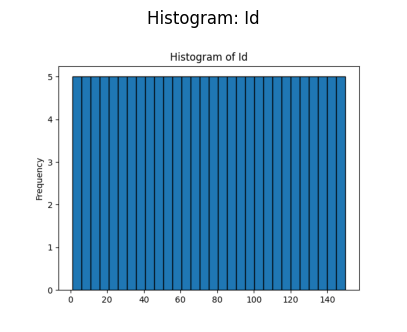

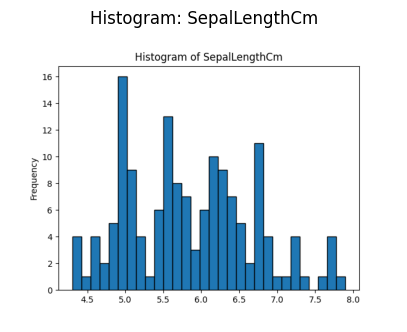

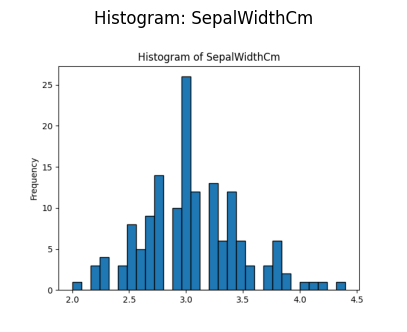

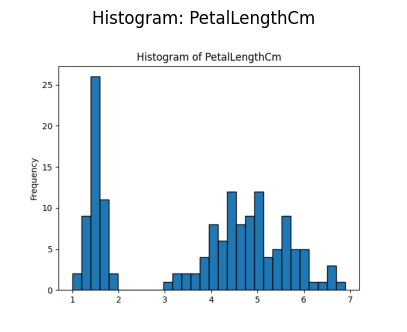

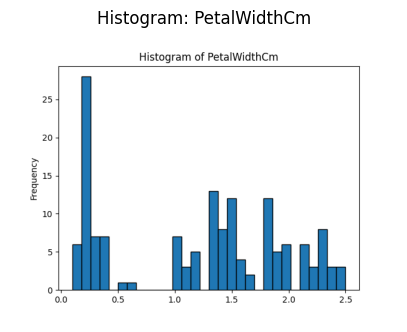

### BOXPLOTS ###


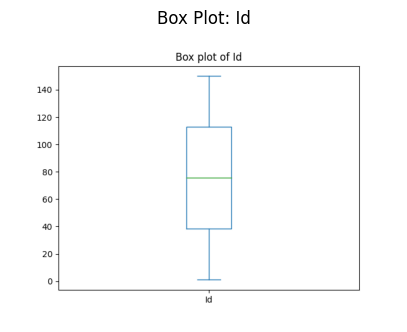

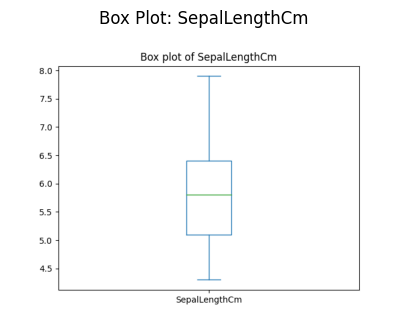

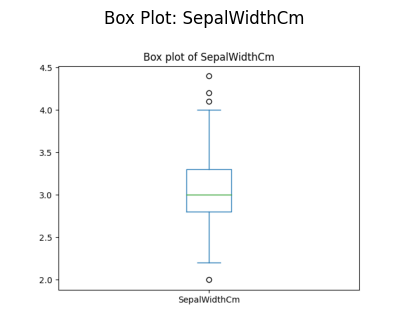

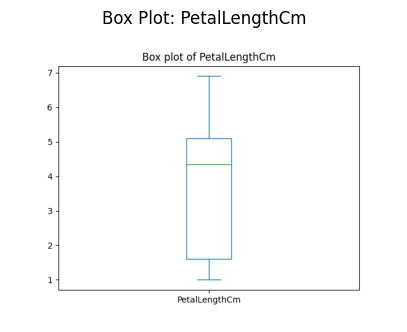

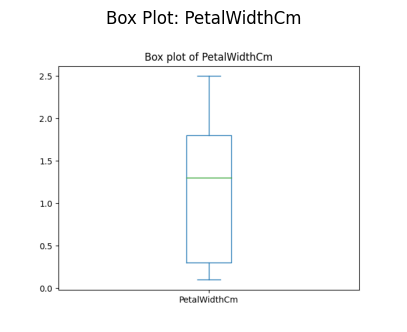

### BAR PLOTS ###


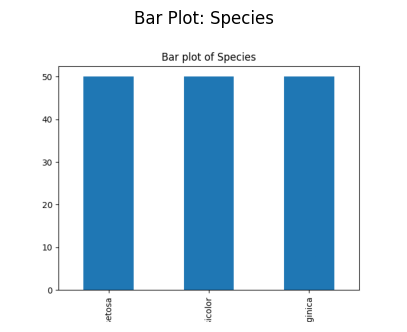

### HEATMAP ###


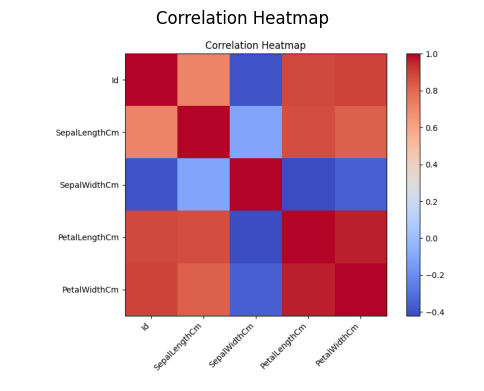

In [56]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# -----------------------
# Display Histograms
# -----------------------
print("### HISTOGRAMS ###")
for item in session["plots"]["histograms"]:
    img = mpimg.imread(item["file"])     # use "file"
    plt.figure(figsize=(5,4))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Histogram: {item['column']}")
    plt.show()

# -----------------------
# Display Box Plots
# -----------------------
print("### BOXPLOTS ###")
for item in session["plots"]["boxplots"]:
    img = mpimg.imread(item["file"])
    plt.figure(figsize=(5,4))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Box Plot: {item['column']}")
    plt.show()

# -----------------------
# Display Bar Plots
# -----------------------
print("### BAR PLOTS ###")
for item in session["plots"]["barplots"]:
    img = mpimg.imread(item["file"])
    plt.figure(figsize=(5,4))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Bar Plot: {item['column']}")
    plt.show()

# -----------------------
# Display Heatmap
# -----------------------
print("### HEATMAP ###")
if session["plots"]["heatmap"]:
    img = mpimg.imread(session["plots"]["heatmap"])
    plt.figure(figsize=(6,5))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Correlation Heatmap")
    plt.show()
else:
    print("No numeric features → No heatmap generated.")
